In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now you can import directly
from examples.libero.schemas import ActionChunk, Timestamp, JSONDataclass
from dataclasses import dataclass

In [2]:
@dataclass
class Metadata(JSONDataclass):
    success: bool
    robot_idx: int
    task_suite_name: str
    task_id: int
    episode_idx: int

In [3]:
@dataclass
class Results:
    action_chunks: list[list[ActionChunk]]
    timestamps: list[list[Timestamp]]
    metadata: list[Metadata]

    @property
    def latencies(self):
        return [chunk.latency for chunks in self.action_chunks for chunk in chunks]

    @property
    def arrival_times(self):
        times = np.array([chunk.request_timestamp for chunks in self.action_chunks for chunk in chunks])
        return times - times.min()

    @property
    def simulation_step_times(self):
        return [curr.timestamp - prev.timestamp for timestamps in self.timestamps for curr, prev in zip(timestamps[1:], timestamps) ]

    @property
    def completion_times(self):
        return [len(timestamps) for timestamps, metadata in zip(self.timestamps, self.metadata) if metadata.success]

    @property
    def success_rate(self):
        return np.mean([metadata.success for metadata in self.metadata])


In [4]:
import os
def load_data(data_dir):
    action_chunk_files = glob.glob(os.path.join(data_dir, "*/*"))
    action_chunk_lists = []
    timestamps_lists = []
    metadata_lists = []
    for f in tqdm(action_chunk_files):
        action_chunk_filepath = os.path.join(f, "action_chunks.csv")
        timestamp_filepath = os.path.join(f, "timestamps.csv")
        chunks = ActionChunk.from_csv(action_chunk_filepath)
        timestamps = Timestamp.from_csv(timestamp_filepath)
        metadata = Metadata.from_json(os.path.join(f, "metadata.json"))
        action_chunk_lists.append(chunks)
        timestamps_lists.append(timestamps)
        metadata_lists.append(metadata)

    results = Results(action_chunks=action_chunk_lists, timestamps=timestamps_lists, metadata=metadata_lists)
    return results

In [5]:
# data_dir = "/nethome/dhe83/flash/openpi/data/libero/multi_robot_videos"
# data_dir = "/nethome/dhe83/flash/openpi/data/libero/sync"
# data_dir = "/nethome/dhe83/flash/openpi/data/libero/benchmark_end_to_end/batch_size_4_num_robots_1_broker_type_SYNC"
template = lambda batch_size, num_robots, broker_type: f"/nethome/dhe83/flash/openpi/data/libero/benchmark_end_to_end/batch_size_{batch_size}_num_robots_{num_robots}_broker_type_{broker_type}"

all_results = []
for broker_type in ["SYNC", "RTC"]:
    for batch_size in tqdm([1, 2, 4], position=0):
        if broker_type == "RTC" and batch_size > 1:
            continue
        for num_robots in tqdm([1, 5, 10, 20], position=1):
            # if broker_type == "RTC" and num_robots > 1:
            #     continue
            results = load_data(template(batch_size, num_robots, broker_type))
            results_dict = {
                "batch_size": batch_size,
                "num_robots": num_robots,
                "broker_type": broker_type,
                "latencies": results.latencies,
                "arrival_times": results.arrival_times,
                "simulation_step_times": results.simulation_step_times,
                "completion_times": results.completion_times,
                "success_rate": results.success_rate
            }
            all_results.append(results_dict)
all_results = pd.DataFrame(all_results)

  0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:00<00:00, 109.99it/s]




100%|██████████| 50/50 [00:00<00:00, 122.19it/s]






100%|██████████| 100/100 [00:00<00:00, 152.45it/s]











100%|██████████| 10/10 [00:00<00:00, 233.10it/s]


100%|██████████| 50/50 [00:00<00:00, 268.24it/s]




100%|██████████| 100/100 [00:00<00:00, 224.32it/s]










100%|██████████| 10/10 [00:00<00:00, 265.92it/s]


100%|██████████| 50/50 [00:00<00:00, 173.39it/s]





100%|██████████| 100/100 [00:00<00:00, 237.12it/s]








100%|██████████| 10/10 [00:00<00:00, 229.24it/s]


100%|██████████| 50/50 [00:00<00:00, 252.97it/s]






100%|██████████| 100/100 [00:00<00:00, 173.68it/s]










100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


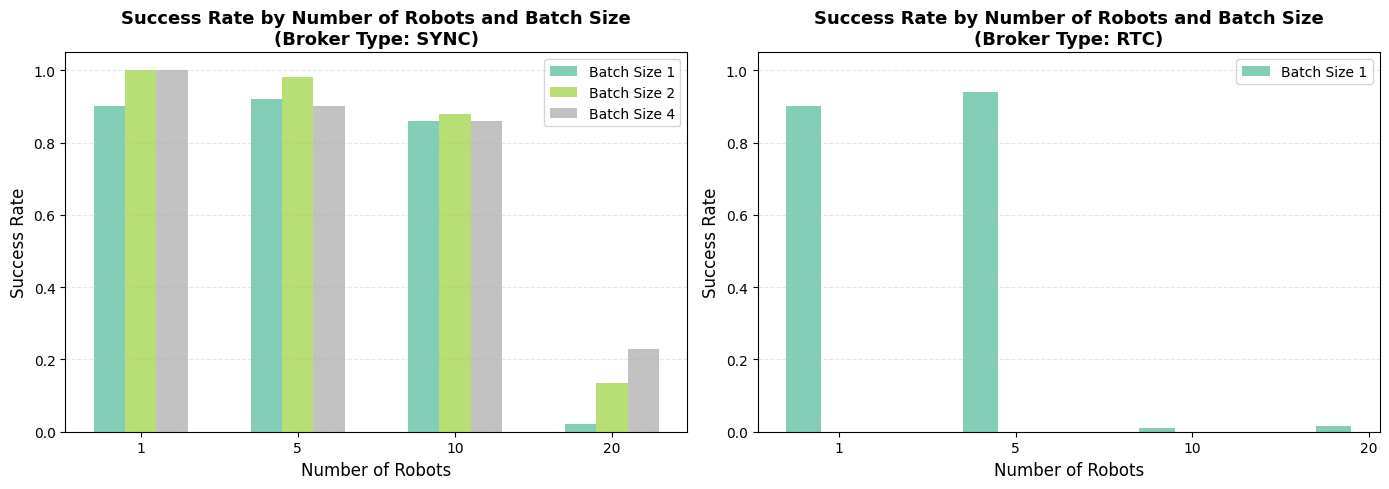

In [6]:
# Create bar plots for success rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

broker_types = all_results['broker_type'].unique()
batch_sizes = sorted(all_results['batch_size'].unique())
num_robots_values = sorted(all_results['num_robots'].unique())

# Color map for different batch sizes
colors = plt.cm.Set2(np.linspace(0, 1, len(batch_sizes)))

for idx, broker_type in enumerate(broker_types):
    ax = axes[idx]
    
    # Filter data for this broker type
    broker_data = all_results[all_results['broker_type'] == broker_type]
    
    # Width of each bar and spacing
    bar_width = 0.2
    x = np.arange(len(broker_data['num_robots'].unique()))
    
    # Plot bars for each batch size
    for i, batch_size in enumerate(batch_sizes):
        batch_data = broker_data[broker_data['batch_size'] == batch_size]
        
        if len(batch_data) > 0:
            # Sort by num_robots to ensure correct ordering
            batch_data = batch_data.sort_values('num_robots')
            
            positions = x[:len(batch_data)] + i * bar_width
            ax.bar(positions, 
                   batch_data['success_rate'], 
                   bar_width, 
                   label=f'Batch Size {batch_size}',
                   color=colors[i],
                   alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('Number of Robots', fontsize=12)
    ax.set_ylabel('Success Rate', fontsize=12)
    ax.set_title(f'Success Rate by Number of Robots and Batch Size\n(Broker Type: {broker_type})', 
                 fontsize=13, fontweight='bold')
    ax.set_xticks(x + bar_width * (len(batch_sizes) - 1) / 2)
    ax.set_xticklabels(sorted(broker_data['num_robots'].unique()))
    ax.set_ylim([0, 1.05])
    ax.legend(loc='best')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [40]:
max(all_results.iloc[15]["simulation_step_times"])

0.49494242668151855

(array([6.9337e+04, 2.4208e+04, 8.4660e+03, 9.2900e+02, 9.5000e+01,
        2.6000e+01, 4.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.01154208, 0.05988212, 0.10822215, 0.15656219, 0.20490222,
        0.25324225, 0.30158229, 0.34992232, 0.39826236, 0.44660239,
        0.49494243]),
 <BarContainer object of 10 artists>)

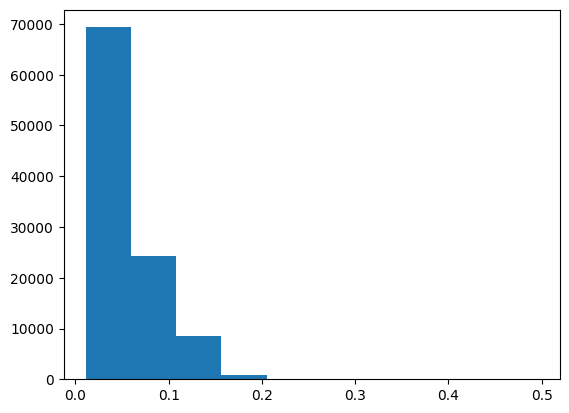

In [ ]:
all_results.iloc[15]["simulation_step_times"]

(array([2., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 1., 0., 1.,
        2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 1., 0.,
        2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 0., 2.,
        2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1.,
        2., 2., 1., 0., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2.,
        1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 1., 1., 2., 1.,
        2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 0., 1., 2., 2.,
        1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 1., 1., 2.,
        2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 0., 2., 1., 2.,
        2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1.,
        1., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1.,
        2., 1.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.

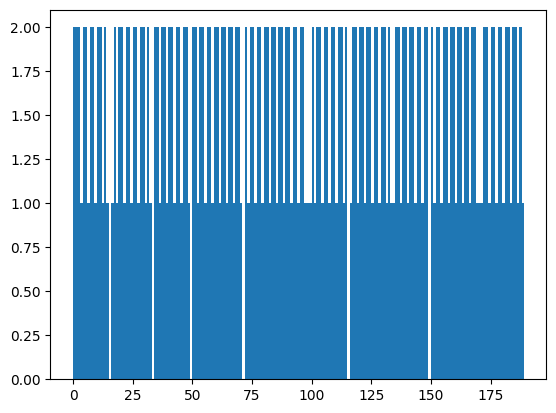

In [30]:
arrival_times= all_results.iloc[0]["arrival_times"]
arrival_times = arrival_times - arrival_times.min()
max_time = arrival_times.max()
bins = np.arange(0, max_time + 1, 1)
plt.hist(arrival_times, bins=bins)

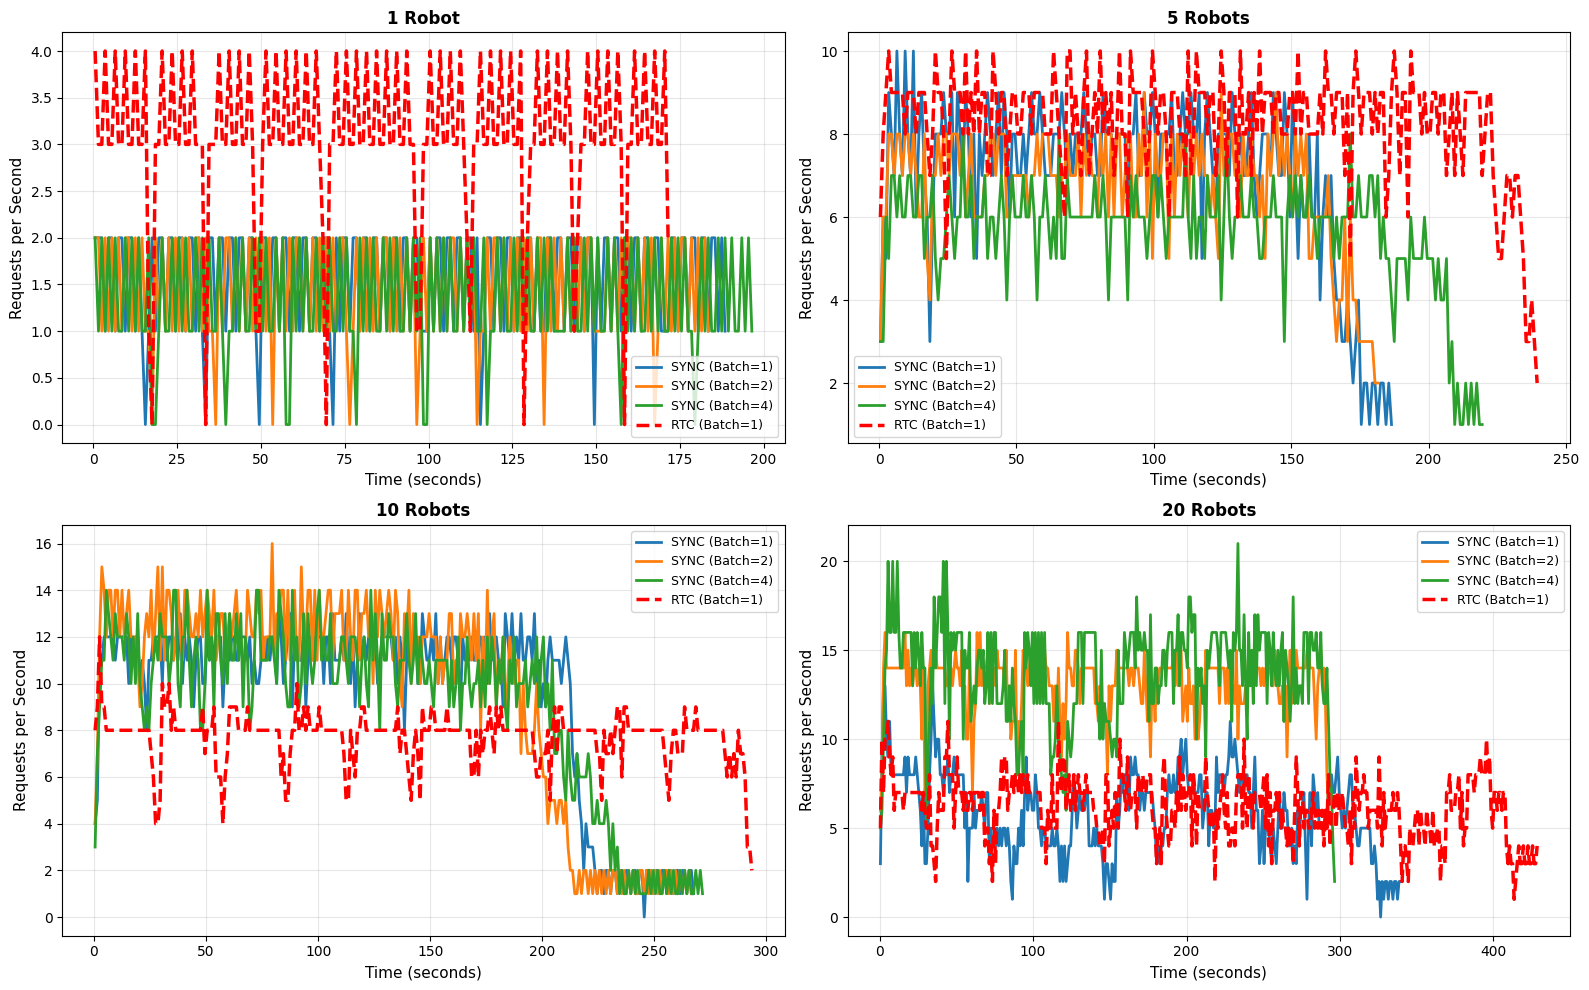

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Function to compute request rate time series
def compute_request_rate_timeseries(arrival_times, bin_size=1.0):
    """Count requests in each time bin (default 1 second bins)"""
    if len(arrival_times) == 0:
        return np.array([]), np.array([])
    
    arrival_times = arrival_times - arrival_times.min()
    max_time = arrival_times.max()
    bins = np.arange(0, max_time + bin_size, bin_size)
    counts, _ = np.histogram(arrival_times, bins=bins)
    time_points = bins[:-1] + bin_size / 2
    
    return time_points, counts

# Create subplots for each num_robots
num_robots_values = sorted(all_results['num_robots'].unique())
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=False, sharey=False)
axes = axes.flatten()

for idx, num_robots in enumerate(num_robots_values):
    ax = axes[idx]
    
    # Plot SYNC configurations
    for batch_size in sorted(all_results[all_results['broker_type'] == 'SYNC']['batch_size'].unique()):
        data = all_results[(all_results['batch_size'] == batch_size) & 
                          (all_results['num_robots'] == num_robots) &
                          (all_results['broker_type'] == 'SYNC')]
        
        if len(data) == 0:
            continue
            
        arrival_times = data.iloc[0]['arrival_times']
        time_points, counts = compute_request_rate_timeseries(arrival_times)
        
        if len(counts) > 0:
            ax.plot(time_points, counts, linewidth=2,
                   label=f'SYNC (Batch={batch_size})')
    
    # Plot RTC configuration
    rtc_data = all_results[(all_results['broker_type'] == 'RTC') & 
                           (all_results['num_robots'] == num_robots)]
    
    if len(rtc_data) > 0:
        arrival_times = rtc_data.iloc[0]['arrival_times']
        time_points, counts = compute_request_rate_timeseries(arrival_times)
        
        if len(counts) > 0:
            ax.plot(time_points, counts, linewidth=2.5, linestyle='--',
                   label='RTC (Batch=1)', color='red')
    
    ax.set_xlabel('Time (seconds)', fontsize=11)
    ax.set_ylabel('Requests per Second', fontsize=11)
    ax.set_title(f'{num_robots} Robot{"s" if num_robots > 1 else ""}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

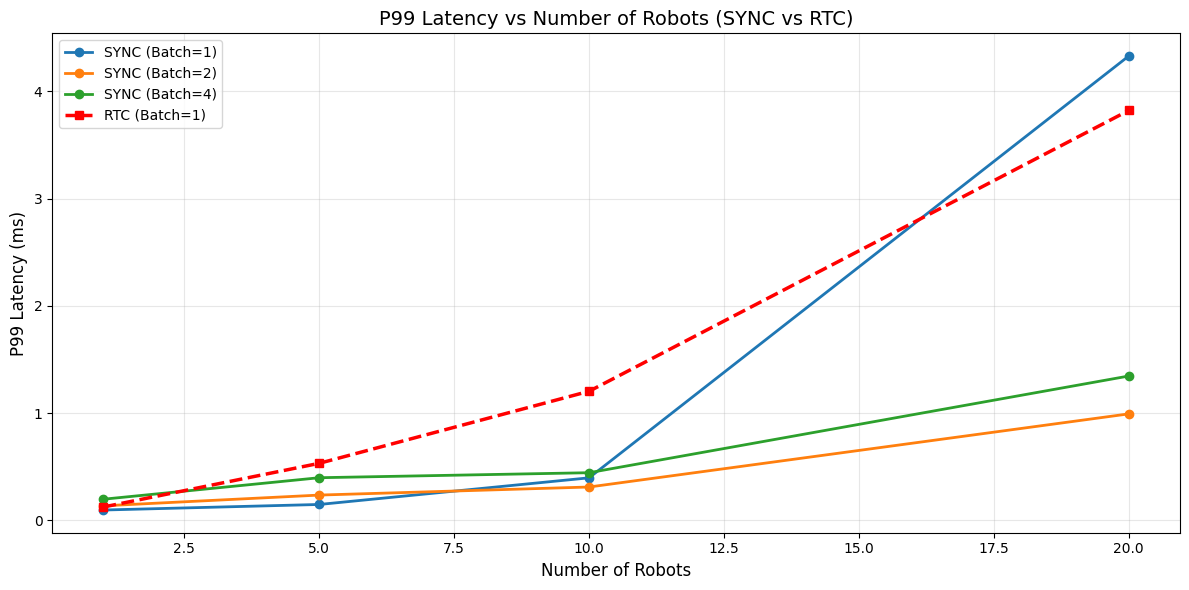

In [8]:
import matplotlib.pyplot as plt

# If p99_latency is not already computed, calculate it from latencies
if 'p99_latency' not in all_results.columns:
    all_results['p99_latency'] = all_results['latencies'].apply(lambda x: np.percentile(x, 99))

# Create the plot
plt.figure(figsize=(12, 6))

# Plot SYNC broker type lines
for batch_size in sorted(all_results[all_results['broker_type'] == 'SYNC']['batch_size'].unique()):
    data = all_results[(all_results['batch_size'] == batch_size) & 
                       (all_results['broker_type'] == 'SYNC')].sort_values('num_robots')
    plt.plot(data['num_robots'], data['p99_latency'], 
             marker='o', linewidth=2, linestyle='-',
             label=f'SYNC (Batch={batch_size})')

# Plot RTC broker type line
rtc_data = all_results[all_results['broker_type'] == 'RTC'].sort_values('num_robots')
if len(rtc_data) > 0:
    plt.plot(rtc_data['num_robots'], rtc_data['p99_latency'], 
             marker='s', linewidth=2.5, linestyle='--',
             label='RTC (Batch=1)', color='red')

plt.xlabel('Number of Robots', fontsize=12)
plt.ylabel('P99 Latency (ms)', fontsize=12)
plt.title('P99 Latency vs Number of Robots (SYNC vs RTC)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

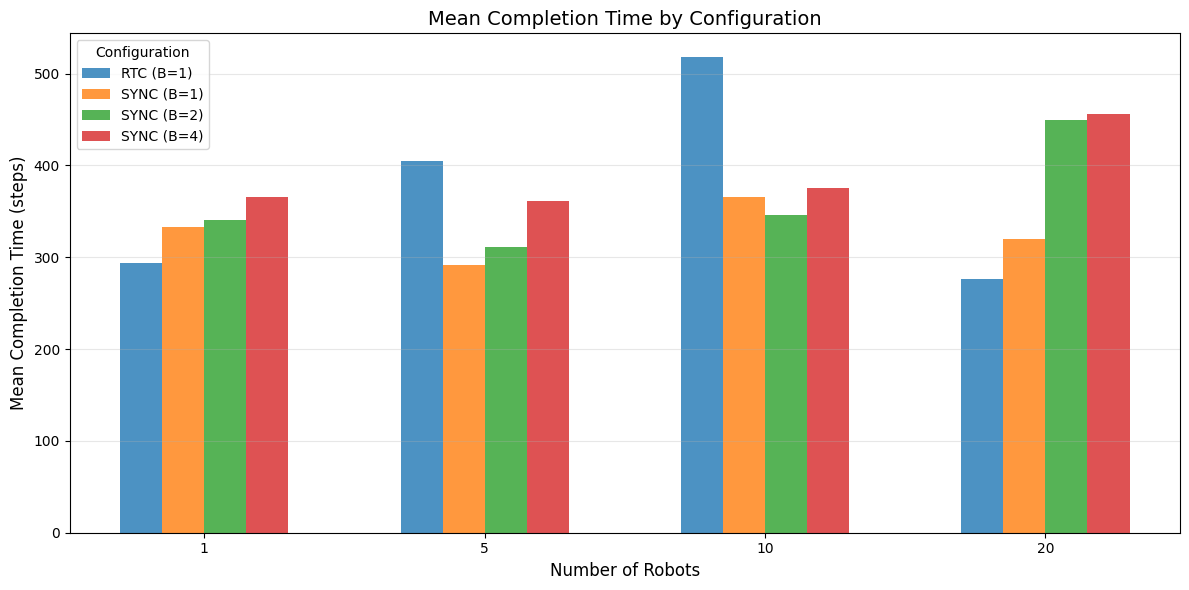

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean completion time for each configuration
if 'mean_completion_time' not in all_results.columns:
    all_results['mean_completion_time'] = all_results['completion_times'].apply(np.mean)

# Get unique combinations
all_results['config'] = all_results.apply(
    lambda row: f"{row['broker_type']} (B={row['batch_size']})", axis=1
)

# Get unique configurations and num_robots
configs = all_results['config'].unique()
num_robots_values = sorted(all_results['num_robots'].unique())

# Set up the bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Width of each bar and spacing
bar_width = 0.15
x_positions = np.arange(len(num_robots_values))

# Plot bars for each configuration
for i, config in enumerate(sorted(configs)):
    config_data = all_results[all_results['config'] == config].sort_values('num_robots')
    
    # Create a mapping from num_robots to completion time
    completion_time_map = dict(zip(config_data['num_robots'], config_data['mean_completion_time']))
    
    # Get completion times in order (use 0 if missing)
    completion_times = [completion_time_map.get(nr, 0) for nr in num_robots_values]
    
    # Plot bars
    offset = (i - len(configs)/2) * bar_width + bar_width/2
    bars = ax.bar(x_positions + offset, completion_times, bar_width, 
                  label=config, alpha=0.8)

ax.set_xlabel('Number of Robots', fontsize=12)
ax.set_ylabel('Mean Completion Time (steps)', fontsize=12)
ax.set_title('Mean Completion Time by Configuration', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels(num_robots_values)
ax.legend(title='Configuration', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

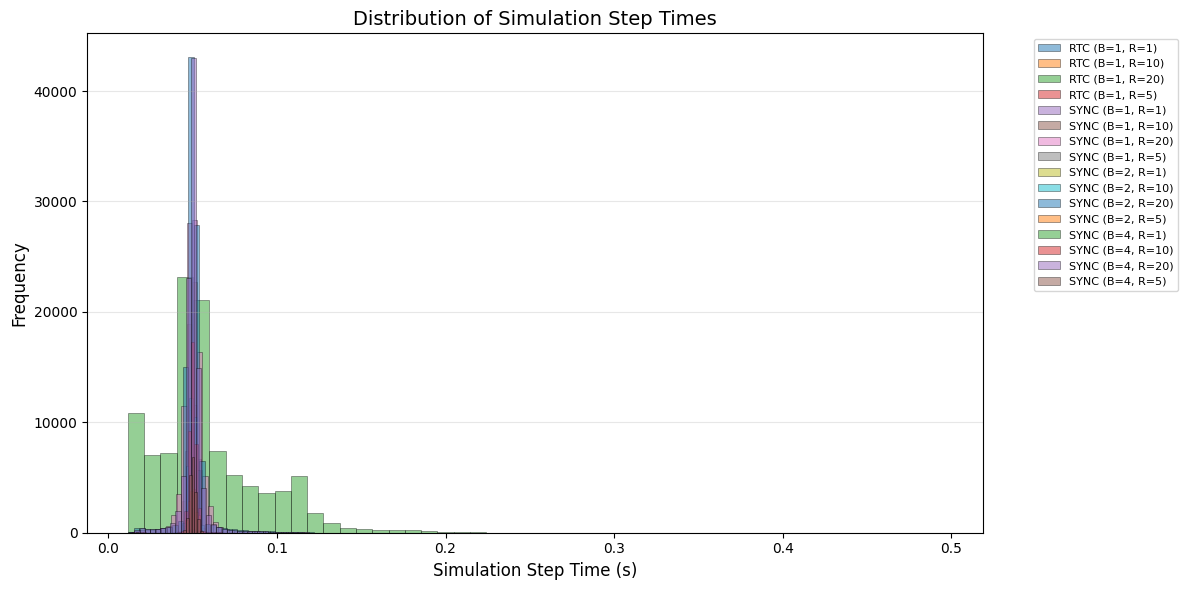

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Combine all simulation step times for each configuration
all_results['config'] = all_results.apply(
    lambda row: f"{row['broker_type']} (B={row['batch_size']}, R={row['num_robots']})", axis=1
)

# Option 1: Overlapping histograms with transparency
fig, ax = plt.subplots(figsize=(12, 6))

for config in sorted(all_results['config'].unique()):
    data = all_results[all_results['config'] == config]
    sim_times = data.iloc[0]['simulation_step_times']
    
    ax.hist(sim_times, bins=50, alpha=0.5, label=config, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Simulation Step Time (s)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Simulation Step Times', fontsize=14)
ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

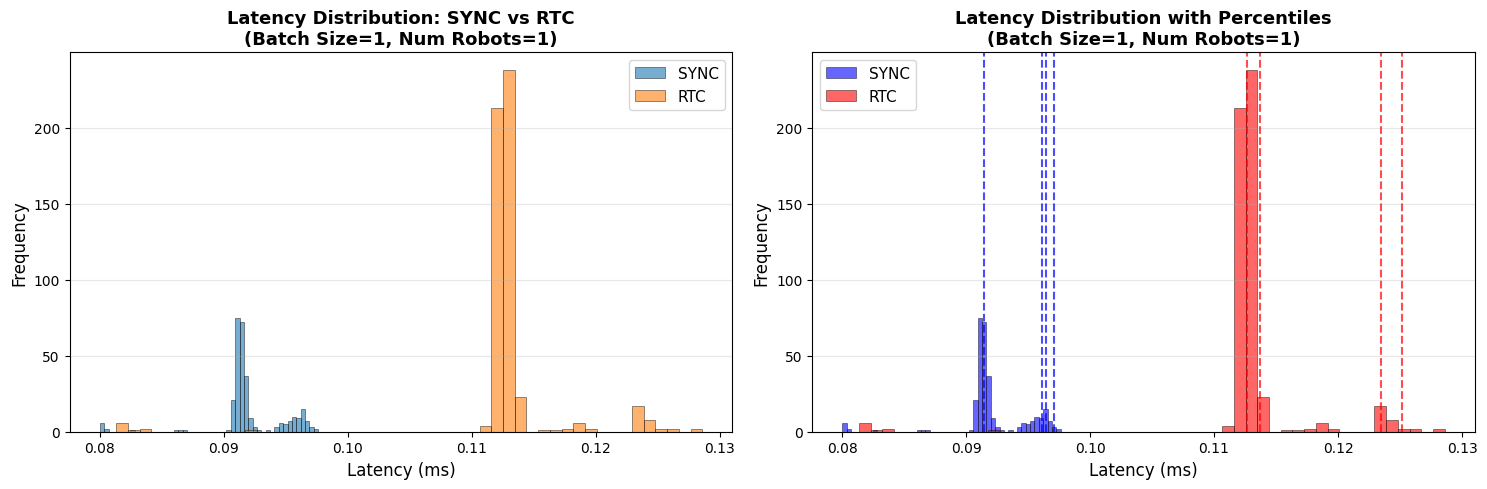


Latency Statistics Comparison:

SYNC:
  Mean:   0.09 ms
  Median: 0.09 ms
  Std:    0.00 ms
  P50:    0.09 ms
  P90:    0.10 ms
  P95:    0.10 ms
  P99:    0.10 ms

RTC:
  Mean:   0.11 ms
  Median: 0.11 ms
  Std:    0.01 ms
  P50:    0.11 ms
  P90:    0.11 ms
  P95:    0.12 ms
  P99:    0.13 ms


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Filter for batch_size=1 and num_robots=1
filtered_data = all_results[(all_results['batch_size'] == 1) & 
                            (all_results['num_robots'] == 1)]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Overlapping histograms
ax1 = axes[0]
for broker_type in ['SYNC', 'RTC']:
    data = filtered_data[filtered_data['broker_type'] == broker_type]
    if len(data) > 0:
        latencies = data.iloc[0]['latencies']
        ax1.hist(latencies, bins=50, alpha=0.6, label=broker_type, 
                edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Latency (ms)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Latency Distribution: SYNC vs RTC\n(Batch Size=1, Num Robots=1)', 
             fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Subplot 2: Side-by-side comparison with percentiles
ax2 = axes[1]
colors = {'SYNC': 'blue', 'RTC': 'red'}
percentiles = [50, 90, 95, 99]

for i, broker_type in enumerate(['SYNC', 'RTC']):
    data = filtered_data[filtered_data['broker_type'] == broker_type]
    if len(data) > 0:
        latencies = data.iloc[0]['latencies']
        
        # Plot histogram
        ax2.hist(latencies, bins=50, alpha=0.6, 
                label=f'{broker_type}', color=colors[broker_type],
                edgecolor='black', linewidth=0.5)
        
        # Add percentile lines
        for p in percentiles:
            value = np.percentile(latencies, p)
            ax2.axvline(value, color=colors[broker_type], linestyle='--', 
                       linewidth=1.5, alpha=0.7)

ax2.set_xlabel('Latency (ms)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Latency Distribution with Percentiles\n(Batch Size=1, Num Robots=1)', 
             fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics for comparison
print("\nLatency Statistics Comparison:")
print("="*60)
for broker_type in ['SYNC', 'RTC']:
    data = filtered_data[filtered_data['broker_type'] == broker_type]
    if len(data) > 0:
        latencies = data.iloc[0]['latencies']
        print(f"\n{broker_type}:")
        print(f"  Mean:   {np.mean(latencies):.2f} ms")
        print(f"  Median: {np.median(latencies):.2f} ms")
        print(f"  Std:    {np.std(latencies):.2f} ms")
        print(f"  P50:    {np.percentile(latencies, 50):.2f} ms")
        print(f"  P90:    {np.percentile(latencies, 90):.2f} ms")
        print(f"  P95:    {np.percentile(latencies, 95):.2f} ms")
        print(f"  P99:    {np.percentile(latencies, 99):.2f} ms")

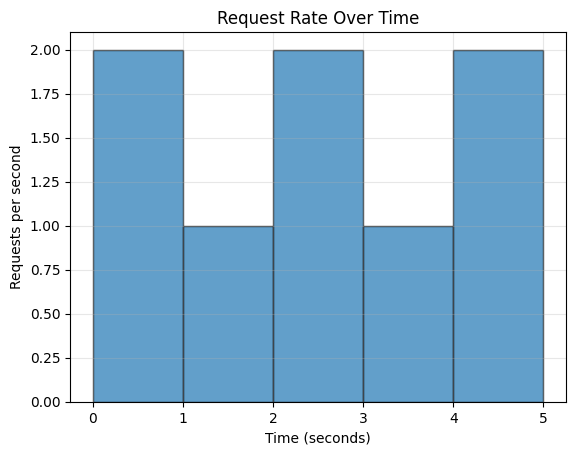

In [43]:
arrival_times = np.array(arrival_times)
arrival_times = arrival_times - min(arrival_times)

# Create bins of exactly size 1
max_time = int(np.ceil(arrival_times.max()))
bins = np.arange(0, max_time + 1, 1)  # [0, 1, 2, 3, ..., max_time]

plt.hist(arrival_times, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Requests per second')
plt.title('Request Rate Over Time')
plt.grid(True, alpha=0.3)
plt.show()

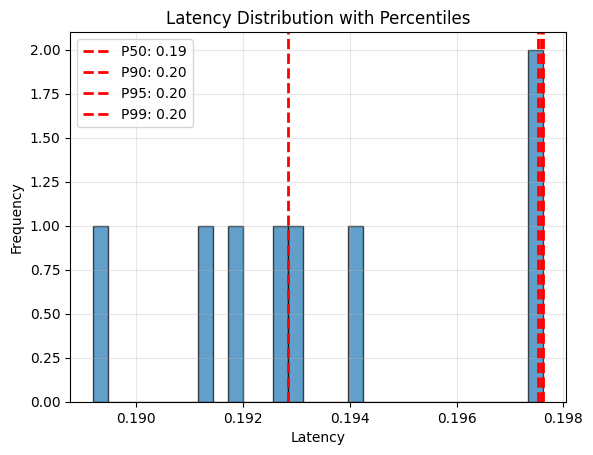

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(latencies, bins=30, alpha=0.7, edgecolor='black')

# Calculate and plot percentiles
percentiles = [50, 90, 95, 99]
for p in percentiles:
    value = np.percentile(latencies, p)
    plt.axvline(value, color='red', linestyle='--', linewidth=2, 
                label=f'P{p}: {value:.2f}')

plt.xlabel('Latency')
plt.ylabel('Frequency')
plt.title('Latency Distribution with Percentiles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()